# $Final \space project \space PDE's \space course$

Primeramente pensamos el problema como uno de autovalores, entonces calculamos el espectro del Hamiltoniano.

In [1]:
import Pkg; Pkg.activate("../gridap_makie"); # activamos el proyecto "gridap_makie" donde se intalarán todos los paquetes

install_packages=false;
if install_packages
    import Pkg
    Pkg.add("GridapGmsh");
    Pkg.add("Gmsh");
    Pkg.add("FileIO");
end

using Gridap;
using GridapGmsh;
using Gmsh;

using Plots;

# crear directorios en caso de no haberlo hecho
create_directories = false;
if (create_directories==true)
    mkdir("../models");
    mkdir("../images");
end

using FileIO;

# en caso de querer plotear dentro de Jupiter Notebook
#  debemos usar algunos paquetes. (no funciona en VSCode)
plot_s = false;
if plot_s
    using GridapMakie, GLMakie; #Para graficar 
    using FileIO;               #Gráficos y salidas
end

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


### Cargamos paquetes específicos para Algebra Lineal

In [2]:
install_packages=false;
if install_packages
    import Pkg
    Pkg.add("LinearAlgebra");
    Pkg.add("SparseArrays");
    Pkg.add("LinearAlgebra");
    Pkg.add("Arpack");
end
using LinearAlgebra;
using SparseArrays;
using SuiteSparse;
using Arpack;

### Incluimos módulo de funciones para resolver problema de autovalores

In [3]:
include("../modules/module_eigen.jl");
include("../models/mesh_generator.jl"); # modulo para construir grilla (1D)

In [4]:
grid_type="1D";
h_1D=1.0/200.0;
par_1D=(0.0,1.0,h_1D) # (Length_x, Length_y, h)

model_1D=make_model(grid_type,par_1D);     # creamos modelo
writevtk(model_1D,"../images/model_1D");  # escribimos el modelo para visualizar con Visit

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000260423s, CPU 0.000251s)
Info    : 201 nodes 202 elements
Info    : Writing '../models/1D.msh'...
Info    : Done writing '../models/1D.msh'
Info    : Reading '../models/1D.msh'...
Info    : 3 entities
Info    : 201 nodes
Info    : 202 elements
Info    : Done reading '../models/1D.msh'


### Definimos condiciones de contorno

In [5]:
# condiciones de contorno
dirichlet_tags_1D=["left","right"];
dirichlet_values_1D=[0.0,0.0]; # 0.0+im*0.0

### Creamos triangulación de la región de integración y del borde

In [6]:
# the triangulation and integration aproximated Lebesgue measure
function measures(model,degree,tags_boundary)
    # triangulation of the integration domain
    Ω=Triangulation(model);
    dΩ=Measure(Ω,degree);
    # triangulation of the boundary domain whit boundary conditions
    Γ=BoundaryTriangulation(model,tags=tags_boundary);
    dΓ=Measure(Γ,degree)
    return Ω,dΩ,Γ,dΓ;
end

function reference_FEspaces(method,type,order)
    reff=ReferenceFE(method,type,order);
    return reff;
end

reference_FEspaces (generic function with 1 method)

In [7]:
Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);

### Creamos espacio de referencia para los elementos finitos

In [8]:
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

### Definimos espacio de prueba y espacio de solución

In [9]:
V_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U_1D=TrialFESpace(V_1D,dirichlet_values_1D);

### Queremos resolver el siguiente problema unidimensional de autovalores:

\begin{align}
    -\frac{\hbar ^{2}}{2m}\frac{\partial }{\partial x}\left(\frac{\partial }{\partial x}\right) \phi(x) +\left[\frac{1}{2} m\omega ^{2}(x-x_{i})^{2}\right] \phi(x) =\lambda \phi(x) \\
    
    \text{si definimos}
    \begin{cases}
        p( x) =\frac{\hbar ^{2}}{2m} \\
        q( x) =\left[\frac{1}{2} m\omega ^{2}(x-x_{i})^{2}\right] \\
        r( x) =1
    \end{cases}
    \Rightarrow \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\right] \phi(x) =\lambda r( x) \phi(x) \\
\end{align}
donde los $\phi(x)$ son los autoestados del hamiltoniano nuclear $h_{x_{i}}$

### Definimos funciones

In [11]:
# declaramos parámetros constantes
const m=1.0;const ω=1.0;const ħ=1.0;const γ=0.1;const x₁=0.0;const x₂=2.0;

In [12]:
pₕ(x) = 0.5*(ħ*ħ)*(1.0/m);
qₕ(x) = 0.5*m*(ω*ω)*(x[1]-x₁)*(x[1]-x₁);
rₕ(x) = 1.0;

### Definimos formas bilineales para el problema débil

+ Weak Form of the Effective Mass Schrodinger Equation
+ Reference: [https://www.physicsforums.com/threads/weak-form-of-the-effective-mass-schrodinger-equation.751282/](https://www.physicsforums.com/threads/weak-form-of-the-effective-mass-schrodinger-equation.751282/)

In [13]:
# deben verificar la integración por partes
function bilineal_forms(pfunc,qfunc,rfunc,dΩ)
    a(u,v) = ∫(pfunc*∇(v)⋅∇(u)+qfunc*v*u)*dΩ;
    b(u,v) = ∫(rfunc*u*v)dΩ;
    return a,b;
end

bilineal_forms (generic function with 1 method)

In [14]:
aₕ_1D,bₕ_1D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D);

### Resolvemos el problema débil de autovalores

In [15]:
nevₕ=12 # number of eigenvalues asked to evaluate.
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,U_1D,V_1D;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

### Graficamos los autovalores

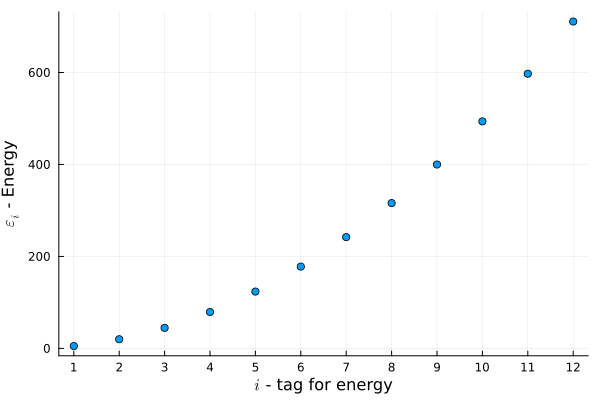

In [16]:
scatter(real(ϵₕ_1D),label="",xlabel="\$i\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:1:nevₕ))

### Graficamos las autofunciones

+ [https://arxiv.org/pdf/1910.01412v2.pdf](https://arxiv.org/pdf/1910.01412v2.pdf)
+ [https://gridap.github.io/Tutorials/dev/pages/t015_interpolation_fe/](https://gridap.github.io/Tutorials/dev/pages/t015_interpolation_fe/)

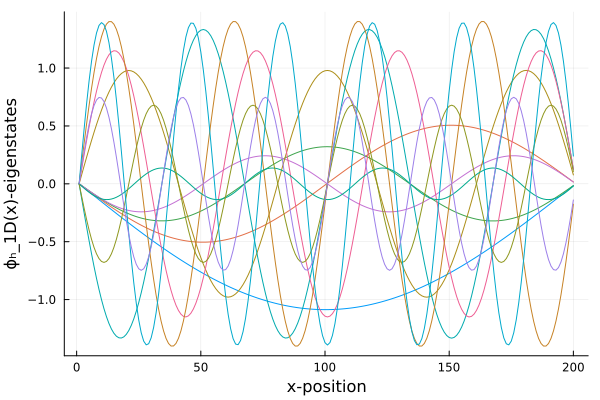

In [17]:
x=[h_1D*(i-1) for i in 1:201];
plt=plot();
plot1=plot!(plt,xlabel="x-position",ylabel="ϕₕ_1D(x)-eigenstates")
for num_eigenvector in 1:nevₕ
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[num_eigenvector],V_1D);
    pts=[Point(x[i]) for i in 1:200];
    plot1=plot!(plt,real(fₕ_1D.(pts)),label="",lw=1);
end
display(plot1);

### Escribimos autovectores para visualizar con Visit

In [18]:
for i in 1:nevₕ
    ϕₕi_1D = ϕₕ_1D[i]; # autovector asociado al autovalor 6
    writevtk(Ω_1D,"../images/eigenprob_01_num$(i)",cellfields=["phi_real" => real(ϕₕi_1D), "phi_imag" => real(ϕₕi_1D)]);
end

<!-- useful links: https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video -->
<!-- https://www.freeconvert.com/mpeg-to-mp4 -->

### Mostramos salida de Autofunciones con visualizador Visit
<video controls width="500">
  <source src="../images/movie_eigenproblem.mp4" type="video/mp4"/>
</video>

### Ahora queremos resolver la dinámica del problema

In [ ]:
# using Gridap.Arrays
# using Gridap.ReferenceFEs
# using Gridap.Algebra
# using SparseArrays
# using Gridap.FESpaces
# using Gridap.CellData

In [ ]:
n_2D=100;dom_2D=(0.0,1.0,0.0,1.0);                             # cantidad de FE y dominio espacial
partition_2D = (n_2D,n_2D);                              # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);  # creamos modelo con elementos cartesianos
writevtk(model_2D,"../images/model_2D");                     # escribimos el modelo para visualizar con Visit

In [ ]:
BCtype="fulldirichlet";
if BCtype=="fulldirichlet"
    println("BCtype = ",BCtype);
    # modified
    labels_2D = get_face_labeling(model_2D);
    add_tag_from_tags!(labels_2D,"D1",[1,7,3,2,4,8]);   # lineas laterales + 4 puntos vértice
    add_tag_from_tags!(labels_2D,"D2",[5,6]);           # lineas superior e inferior
    dirichlet_values_2D=[0.0,0.0]; # 0.0+im*0.0
end

In [ ]:
Ω_1D,dΩ_1D,Γ_2D,dΓ_2D=measures(model_2D,3,["D1","D2"]);

In [ ]:
order_2D=2;reffe_2D=ReferenceFE(lagrangian,Float64,order_2D);

In [ ]:
Vₕ_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["D1","D2"]);
Uₕ_2D=TrialFESpace(Vₕ_2D,dirichlet_values_2D);

In [ ]:
aₕ_2D,bₕ_2D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_2D);
probₕ_2D=EigenProblem(aₕ_2D,bₕ_2D,Uₕ_2D,Vₕ_2D;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_2D,ϕₕ_2D=solve(probₕ_2D);

In [ ]:
path_dir::String = "../images/";

In [ ]:
particle = true;
if particle
    save_file = save_file * "particle"
    T=5;            # final time for test
    num_steps=2000; # number of time steps   
    n_int=100;      # Intervals where data is saved
end

In [ ]:
dt=T/(num_steps-1) # time step
println("dt/dx²=$(dt*n_2D^2) dt/dx=$(dt*n_2D) dt³/dx⁶=$((dt*n_2D^2)^3)")

In [ ]:
function norm_L2(u,dΩ)
    return sqrt(real(sum(∫(u'*u)*dΩ)));
end

In [ ]:
function u_0_particle(x, par)
    r0,xi,k,p=par
    r=sqrt((x[1]-xi[1])^2+(x[2]-xi[2])^2)
    kx=2π*(k[1]*(x[1]-xi[1])+k[2]*(x[2]-xi[2]))
    if (r<r0)
        return (r-r0)^p * (r-r0)^p * (4^(2p)) * exp(im*kx)
    else
        return 0.0 + 0.0*im
    end
end

if particle
    par_particle = (0.4, [0.25; 0.25], [-16; 16], 4)
    u_0_particle([0.5;0.5], par_particle)
    u_0(x) = u_0_particle(x, par_particle)
end

In [ ]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["D1","D2"]);
U₁H_2D=TrialFESpace(V₁H_2D,dirichlet_values_2D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=["D1","D2"]);
U₂H_2D=TrialFESpace(V₂H_2D,dirichlet_values_2D);
# creamos un campo de espacios
UH_2D = MultiFieldFESpace([U₁H_2D, U₂H_2D]);
VH_2D = MultiFieldFESpace([V₁H_2D, V₂H_2D]);

### creamos condición inicial

In [ ]:
u₀ₕ_2D=interpolate_everywhere(ϕₕ_2D[1],Vₕ_2D);
interp_u₀ₕ_2D=Interpolable(u₀ₕ_2D);
u₁0H_2D=interpolate_everywhere(interp_u₀ₕ_2D,V₁H_2D);

In [ ]:
u₂0H_2D(x) = 0.0;

In [ ]:
u₀H_2D=interpolate_everywhere([u₁0H_2D,u₂0H_2D],VH_2D);

In [ ]:
writevtk(Ω_2D,"../images/evol_ini_dat_$(lpad(0,3,'0'))", cellfields=["u₁0H_2D_re"=>real(u₀H_2D[1]),"u₁0H_2D_im"=>imag(u₀H_2D[1])])
norm_L2(u₀H_2D[1])

In [ ]:
m=1.0;ω=1.0;ħ=1.0;γ=0.1;x₁=0.0;x₂=2.0;
pH(x) = -0.5*(ħ*ħ)*(1.0/m);
q₁H(x) = 0.5*m*(ω*ω)*x[1]*x[1];
q₂H(x) = γ; 

In [ ]:
assem_H=SparseMatrixAssembler(UH_2D,VH_2D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_2D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_2D);                   # escribimos u en la base de FE de U

In [ ]:
# deben verificar la integración por partes
function a_bilineal_forms_2D(pfunc,q₁func,q₂func,dΩ)
    a((u₁,u₂),(v₁,v₂))=∫((pfunc*∇(v₁)⋅∇(u₁)+pfunc*∇(v₂)⋅∇(u₂)+
                          q₁func*v₁*u₁+q₂func*v₂*u₂)dt+
                          (im*2.0*v₁*u₁+im*2.0*v₁*u₁))*dΩ;
    return a;
end

function b_bilineal_form_2D(q₁func,q₂func,u₀H_2D,dΩ)
    b(v₁,v₂)=∫((∇(v₁)⋅∇(-u₀H_2D[1])+q₁func*v₁*(-u₀H_2D[1])+
                ∇(v₂)⋅∇(-u₀H_2D[2])+q₂func*v₂*(-u₀H_2D[2]))*dt+
                (im*2*v₁*u₀H_2D[1]+im*2*v₂*u₀H_2D[2]))dΩ
    return b;
end 

In [ ]:
a_H_2D=a_bilineal_forms_2D(pH,q₁H,q₂H,dΩ_2D);
mat_contribs_H=a_H_2D(du_H,dv_H);                      # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_2D,VH_2D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);              # creamos matriz A con contribuciones y datos

In [ ]:
t=0;  # inicializamos variable tiempo
writevtk(Ω_2D,path_dir*"evol__$(lpad(0,3,'0'))",
cellfields=["u₁H_2D_re" => real(u₀H_2D[1]), "u₁H_2D_im" => imag(u₀H_2D[1]),"u₂H_2D_re" => real(u₀H_2D[2]), "u₂H_2D_im" => imag(u₀H_2D[2])])

for istep in 1:num_steps
  # println("\n+++ Solving in step $istep of $num_steps +++\n")
  b_H_2D=b_bilineal_form_2D(q₁H,q₂H,u₀H_2D,dΩ_2D)
  vec_contribs_H=b_H_2D(dv_H[1],dv_H[2])
  data_H=collect_cell_vector(VH_2D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)

  x_H = A_H \ b_H
  t = t + dt
  uH_2D = FEFunction(UH_2D,x_H)

  u₀H_2D = uH_2D

  if ((istep - 1) % n_int == 0) && (istep > 1)
    writevtk(Ω_2D,path_dir*"evol__$(lpad(istep,3,'0'))",
    cellfields=[ "u₁H_2D_re" => real(u₀H_2D[1]), "u₁H_2D_im" => imag(u₀H_2D[1]),"u₂H_2D_re" => real(u₀H_2D[2]), "u₂H_2D_im" => imag(u₀H_2D[2])])
  end
end

### Mostramos salida de Densidad de probabilidad con visualizador Visit
<video controls width="500">
  <source src="./images/movie_density.mp4" type="video/mp4"/>
</video>